In [3]:
# Data stuffs
import pickle 
import numpy as np
import pandas as pd
import pathlib 
import os, sys
from moxie.data.utils_ import load_data, standardize, de_standardize, normalize_profiles

# Plotting
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec

# Make it look pretty
from IPython.display import display, HTML
from tqdm.notebook import tqdm  

# ML Stuff
import torch 
from torch.nn import functional as F
from moxie.models.DIVA_ak_2 import DIVAMODEL
from moxie.data.profile_lightning_module import PLDATAMODULE_AK
from moxie.experiments.DIVA_EXP_AK_1 import EXAMPLE_DIVA_EXP_AK
from moxie.models.utils_ import conditional_inference_simple_mean

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
%matplotlib widget

In [37]:
# Load data 
train_data, val_data, test_data = load_data(dataset_choice='SANDBOX_NO_VARIATIONS', file_loc='../../../moxie/data/processed/pedestal_profiles_ML_READY_ak_5052022_uncerts_mask.pickle', elm_timings=False)
# (train_X, train_y, train_mask, train_radii, train_real_space_radii, train_ids, train_uncert, train_elm_timings), (val_X, val_y, val_mask, val_radii, val_real_space_radii, val_ids, val_uncert, val_elm_timings), (test_X, test_y, test_mask, test_radii, test_real_space_radii, test_ids, test_uncert, test_elm_timings) = train_data, val_data, test_data
(train_X, train_y, train_mask, train_radii, train_real_space_radii, train_ids, train_uncert), (val_X, val_y, val_mask, val_radii, val_real_space_radii, val_ids, val_uncert), (test_X, test_y, test_mask, test_radii, test_real_space_radii, test_ids, test_uncert) = train_data, val_data, test_data

with open('../../data/processed/new_elm_timings_idxs.pickle', 'rb') as file: 
    ELM_TIMING_DICT = pickle.load(file) 

train_new_pulse_ids, train_elm_percentages = ELM_TIMING_DICT['train']['pulse_idx'], ELM_TIMING_DICT['train']['elm_percentages']
val_new_pulse_ids, val_elm_percentages = ELM_TIMING_DICT['val']['pulse_idx'], ELM_TIMING_DICT['val']['elm_percentages']
test_new_pulse_ids, test_elm_percentages = ELM_TIMING_DICT['test']['pulse_idx'], ELM_TIMING_DICT['test']['elm_percentages']

machine_param_order = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']
JET_PDB = pd.read_csv('../../../moxie/data/processed/jet-pedestal-database.csv')
PULSE_DF_SANDBOX = JET_PDB[(JET_PDB['FLAG:HRTSdatavalidated'] > 0) & (JET_PDB['shot'] > 80000) & (JET_PDB['Atomicnumberofseededimpurity'].isin([0, 7])) & (JET_PDB['FLAG:DEUTERIUM'] == 1.0) & (JET_PDB['FLAG:Kicks'] == 0.0) & (JET_PDB['FLAG:RMP'] == 0.0) & (JET_PDB['FLAG:pellets'] == 0.0)]
relevant_columns = ['shot', 'nepedheight10^19(m^-3)','Tepedheight(keV)', 'B(T)','Ip(MA)', 'q95',  'R(m)', 'a(m)','gasflowrateofmainspecies10^22(e/s)',  'P_TOT=PNBI+Pohm+PICRH-Pshi(MW)', 'P_ICRH(MW)', 'P_NBI(MW)','plasmavolume(m^3)', 'averagetriangularity', 'divertorconfiguration', 'FLAG:Seeding', 'FLAG:Kicks',
 'FLAG:RMP',
 'FLAG:pellets',]


FLAGS = [x for x in JET_PDB.columns.to_list() if 'FLAG' in x]



train_pulse_order = [int(x.split('/')[0]) for x in train_ids]
train_pulses = list(set(train_pulse_order))
train_pulse_idxs = [[index for index in range(len(train_pulse_order)) if train_pulse_order[index] == pulse] for pulse in train_pulses]

val_pulse_order = [int(x.split('/')[0]) for x in val_ids]
val_pulses = list(set(val_pulse_order))
val_pulse_idxs = [[index for index in range(len(val_pulse_order)) if val_pulse_order[index] == pulse] for pulse in val_pulses]

test_pulse_order = [int(x.split('/')[0]) for x in test_ids]
test_pulses = list(set(test_pulse_order))
test_pulse_idxs = [[index for index in range(len(test_pulse_order)) if test_pulse_order[index] == pulse] for pulse in test_pulses]


In [63]:
from scipy.stats import truncnorm
# boilerplate stuff
import math
from collections.abc import Iterable
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import savgol_filter
class RunningStats:
    def __init__(self):
        self.n = 0
        self.old_m = 0
        self.new_m = 0
        self.old_s = 0
        self.new_s = 0

    def clear(self):
        self.n = 0

    def push(self, x):
        if isinstance(x, Iterable):
            for v in x:
                self.push(v)
            return

        self.n += 1

        if self.n == 1:
            self.old_m = self.new_m = x
            self.old_s = 0
        else:
            self.new_m = self.old_m + (x - self.old_m) / self.n
            self.new_s = self.old_s + (x - self.old_m) * (x - self.new_m)

            self.old_m = self.new_m
            self.old_s = self.new_s

    def mean(self):
        return self.new_m if self.n else 0.0

    def variance(self):
        return self.new_s / (self.n - 1) if self.n > 1 else 0.0

    def standard_deviation(self):
        return math.sqrt(self.variance())

    def __repr__(self):
        return f'n: {self.n}, mean: {self.mean()}, var: {self.variance()}, sd: {self.standard_deviation()}'
    
def standardize_signal(x, trim_zeros=True):
    if trim_zeros:
        x_in = np.trim_zeros(x)
    else:
        x_in = x
    rs = RunningStats() # numpy.std goes to inf so do it by hand
    rs.push(x_in)
    return (x - rs.mean()) / rs.standard_deviation()

In [76]:
def determine_pedestal_top_rval(x, p, plot_result=False): 
    # standardize signal
    p = standardize_signal(p, trim_zeros=True)

    # interp signal to Nx=50
    f_interp = interpolate.interp1d(x, p)
    x_h = np.linspace(x[0], x[-1], 50)  # interpolate to 50 (evenly spaced) points
    p_h = f_interp(x_h)

    # smooth with savgol filter
    p_s = savgol_filter(p_h, window_length=11, polyorder=3)

    # get max gradient so we're in the pedestal
    p_s_grad = np.gradient(p_s)
    min_i = np.argmin(p_s_grad)


    # search from pedestal region outward in 2nd derivatives
    p_s_grad2 = np.gradient(p_s_grad)
    p_s_grad2 = savgol_filter(p_s_grad2, window_length=11, polyorder=3)  # aggressively smooth as well
    p_s_grad2 = standardize_signal(p_s_grad2, trim_zeros=True)
    # standardize s.t. if we go >1 sd up/down, we stop searching

    # go to the left from middle point
    sd_cutoff = -.5
    start_cut_early = False  # if we go < -1 for x'', mark as such, such that if we go > -1 again we stop looking
    min_val = p_s_grad2[min_i]
    top_i = min_i
    for i in reversed(range(0, min_i)):
        if p_s_grad2[i] < min_val:
            min_val = p_s_grad2[i]
            top_i = i
            if min_val < sd_cutoff:
                start_cut_early = True
        elif start_cut_early and p_s_grad2[i] > sd_cutoff:
            break

    # found our x for top
    # same procedure for bottom
    sd_cutoff = .5
    start_cut_early = False  # if we go > 1 for x'', etc.
    max_val = p_s_grad2[min_i]
    bottom_i = min_i

    for i in range(min_i+1, x_h.shape[0]):
        if p_s_grad2[i] > max_val:
            max_val = p_s_grad2[i]
            bottom_i = i
            if max_val > sd_cutoff:
                start_cut_early = True
        elif start_cut_early and p_s_grad2[i] < sd_cutoff:
            break

    top, bottom = x_h[top_i], x_h[bottom_i]
    top_left_one = x_h[top_i - 1]

    if plot_result:
        plt.plot(x_h, p_s)
        plt.plot(x, p)
        plt.axvline(top, color='red')
        plt.axvline(bottom, color='blue')
        plt.show()
    return top, bottom


def calculate_nesep_for_pulse(both_profiles, both_uncertanties, integer_masks, pulse_rmids, lbound_n, ubound_n, lbound_t, ubound_t, ubound_tsep=120, lbound_tsep=80, rad_var=0.01, conditional_prediction=False, local_pulse_number=None, check_SOL_radius=False):
    """
    This will return the neseps predicted for each time slice in the pulse. 
    """
    SOL_width = 0.020
    slices_skipped = 0

    pulse_neseps, pulse_teseps, pulse_rtops = np.full(len(both_profiles), np.nan),  np.full(len(both_profiles), np.nan), np.full(len(both_profiles), np.nan)    
    pulse_teseps_masked, pulse_neseps_masked =  np.full(len(both_profiles), np.nan), np.full(len(both_profiles), np.nan)
    
    if conditional_prediction: 
        integer_masks = np.ones_like(integer_masks, dtype=bool)
        both_uncertanties = np.ones_like(both_uncertanties, dtype=bool)*200
    
    for r, (both_profiles_slice, both_uncertanties_slice, mask_int_slice, slice_rmid) in enumerate(zip(both_profiles, both_uncertanties, integer_masks, pulse_rmids)):
        bool_mask = mask_int_slice > 0
        # bool_mask = np.logical_and(bool_mask, both_uncertanties_slice[0, :] < 1e19)
        slice_ne, slice_te = both_profiles_slice[0, :][bool_mask], both_profiles_slice[1, :][bool_mask]
        slice_ne_uncert, slice_te_uncert = both_uncertanties_slice[0, :][bool_mask], both_uncertanties_slice[1, :][bool_mask]
        slice_rmid_mask = slice_rmid[bool_mask]
        
        """
        sep_diff = slice_te - 100
        lower_than_100 = sep_diff < 0
        offset = 0.1
        # First determine the upper bound 
        
        # tupper_bound =  np.argmin(sep_diff[larger_than_100])
        # tlower_bound = np.where(sep_diff < 0)
        if (sep_diff < 0).any() == False:
            idx_tlower_bound = -1
            continue
            # int('oh shit', slice_te)
            sep_diff = slice_te - 100
            lower_than_100 = sep_diff < 0
            if (sep_diff < 0).any() == False: 
                print('oh shit shit')
                idx_tlower_bound = -1
            else: 
                idx_tlower_bound = np.argwhere(sep_diff < 0)[0][0]
            # idx_tlower_bound = -1
            offset = 0.1
        else: 
            idx_tlower_bound = np.argwhere(sep_diff < 0)[0][0]
            offset = 0        
        
        idx_thigher_bound = idx_tlower_bound -1
        """
        # print(slice_te)
        # print(slice_te[tlower_bound][0])
        
        r_ped_top, r_ped_bot = determine_pedestal_top_rval(slice_rmid_mask, slice_ne)
        # ubound_r = slice_rmid_mask[idx_tlower_bound] # + offset
        # lbound_r = slice_rmid_mask[idx_thigher_bound] # - offset

        # radii_gaussians = np.array([truncnorm.rvs((lbound_r - mu) / var, (ubound_r - mu) / var, mu, var, 10000) for mu, var in zip(slice_rmid_mask, [rad_var]*len(slice_rmid_mask))])

        
        tes_gaussians = np.array([truncnorm.rvs((lbound_t - mu) / var, (ubound_t - mu) / var, mu, var, 10000) for mu, var in zip(slice_te, slice_te_uncert)])
        nes_gaussians = np.array([truncnorm.rvs((lbound_n - mu) / var, (ubound_n - mu) / var, mu, var, 10000) for mu, var in zip(slice_ne, slice_ne_uncert)])
        
        separatrix_loc = np.logical_and(tes_gaussians >= lbound_tsep, tes_gaussians <= ubound_tsep)
        
        tesep_in_separatrix = tes_gaussians[separatrix_loc]
        nes_in_separatrix = nes_gaussians[separatrix_loc]
        
        slice_nesep = np.mean(nes_in_separatrix)
        slice_tesep = np.mean(tesep_in_separatrix)
        
        pulse_neseps[r] = slice_nesep
        pulse_teseps[r] = slice_tesep
        
        pulse_rtops[r] = r_ped_top 
        
        
    rsep_mean = pulse_rtops.mean()
    rsep_cutoff = pulse_rtops.mean() + pulse_rtops.std()
    for n, (both_profiles_slice, both_uncertanties_slice, mask_int_slice, slice_rmid) in enumerate(zip(both_profiles, both_uncertanties, integer_masks, pulse_rmids)):
        if np.isnan(pulse_rtops[n]): 
            print('yeah fuck that')
            slices_skipped += 1
            continue
        bool_mask = mask_int_slice > 0
        # bool_mask = np.logical_and(bool_mask, both_uncertanties_slice[0, :] < 1.5e19)
        slice_ne, slice_te = both_profiles_slice[0, :][bool_mask], both_profiles_slice[1, :][bool_mask]
        slice_ne_uncert, slice_te_uncert = both_uncertanties_slice[0, :][bool_mask], both_uncertanties_slice[1, :][bool_mask]
        slice_rmid_mask = slice_rmid[bool_mask]
        
        # Update the boolean mask to include SOL 
        
        rsep_slice_cutoff = pulse_rtops[n]
        if rsep_slice_cutoff > rsep_cutoff: 
            rsep_slice_cutoff = rsep_mean
            
        SOL_mask = np.logical_and(slice_rmid_mask >= rsep_slice_cutoff, slice_rmid_mask < rsep_slice_cutoff + SOL_width)
        # SOL_mask = np.logical_and(slice_te > 30, slice_te < 500)
        
        slice_ne_SOL_masked, slice_ne_uncert_SOL_masked = slice_ne[SOL_mask], slice_ne_uncert[SOL_mask]
        slice_te_SOL_masked, slice_te_uncert_SOL_masked = slice_te[SOL_mask], slice_te_uncert[SOL_mask]
        
        if len(slice_te_SOL_masked) == 0: 
            SOL_mask = np.logical_and(slice_rmid_mask > rsep_slice_cutoff - 0.01, slice_rmid_mask < rsep_slice_cutoff + SOL_width + 0.01)
            slice_ne_SOL_masked, slice_ne_uncert_SOL_masked = slice_ne[SOL_mask], slice_ne_uncert[SOL_mask]
            slice_te_SOL_masked, slice_te_uncert_SOL_masked = slice_te[SOL_mask], slice_te_uncert[SOL_mask]
        # SOL_mask = np.logical_and(slice_te > 30, slice_te < 500)
        
        
        
        tes_gaussians_masked = np.array([truncnorm.rvs((lbound_t - mu) / var, (ubound_t - mu) / var, mu, var, 10000) for mu, var in zip(slice_te_SOL_masked, slice_te_uncert_SOL_masked)])
        nes_gaussians_masked = np.array([truncnorm.rvs((lbound_n - mu) / var, (ubound_n - mu) / var, mu, var, 10000) for mu, var in zip(slice_ne_SOL_masked, slice_ne_uncert_SOL_masked)])
        
        # tes_gaussians_masked = np.array([np.linspace(truncnorm.ppf(0.01, (lbound_t - mu) / var, (ubound_t - mu) / var, mu, var), 
        #                              truncnorm.ppf(0.99, (lbound_t - mu) / var, (ubound_t - mu) / var, mu, var), 10000)
        #                 for mu, var in zip(slice_te_SOL_masked, slice_te_uncert_SOL_masked)])
        
        separatrix_loc_masked = np.logical_and(tes_gaussians_masked > 80, tes_gaussians_masked < 120)
        tesep_in_separatrix_masked = tes_gaussians_masked[separatrix_loc_masked]
        nes_in_separatrix_masked = nes_gaussians_masked[separatrix_loc_masked]
        
        # nes_gaussians_masked = np.array([np.linspace(truncnorm.ppf(0.01, (lbound_n - mu) / var, (ubound_n - mu) / var, mu, var), 
        #                              truncnorm.ppf(0.99, (lbound_n - mu) / var, (ubound_n - mu) / var, mu, var), 10000)
        #                 for mu, var in zip(slice_ne_SOL_masked, slice_ne_uncert_SOL_masked)])
        
        
        
        if len(nes_in_separatrix_masked) == 0:
            print(slice_rmid_mask, rsep_slice_cutoff)
            print('limit low', rsep_slice_cutoff,)
            print('limit high', rsep_slice_cutoff + SOL_width,)
            print(slice_te, )
            print('shit', local_pulse_number)
            
            if len(nes_in_separatrix) == 0: 
                print('fuck')
            # print(slice_rmid_mask, rsep)
            # print('\nPremask', slice_ne, slice_te, slice_ne_uncert, slice_te_uncert)
            # print('\n mask', slice_ne_SOL_masked, slice_te_SOL_masked, slice_ne_uncert_SOL_masked, slice_te_uncert_SOL_masked)
        
        slice_nesep_masked = np.mean(nes_in_separatrix_masked)
        slice_tesep_masked = np.mean(tesep_in_separatrix_masked)
        
        pulse_teseps_masked[n] = slice_tesep_masked
        pulse_neseps_masked[n] = slice_nesep_masked
        
        
    # print('mask te', pulse_teseps_masked, '\npre te', pulse_teseps, '\nrsep', pulse_rseps, pulse_rseps.mean(),  '\n neseps', pulse_neseps, pulse_neseps.std())
    return pulse_neseps, pulse_teseps, pulse_neseps_masked, pulse_teseps_masked, slices_skipped

def calculate_neseps_in_set(set_ids, set_profiles, set_uncerts, set_masks, set_shot_numbers_by_slice, set_rmids, new_elm_ids, pedestal_database, set_elm_timings=None, ubound_tsep=120, lbound_tsep=80, rad_var=0.015, ): 
    iterator = tqdm(range(len(set_ids)))
    
    neseps_means_lorenzo_masked = np.zeros((3, len(set_ids)))
    teseps_means = np.zeros(len(set_ids))
    nesep_means_by_pulse, tesep_means_by_pulse, elm_timings_by_pulse, nesep_means_by_pulse_masked = [], [], [], []
    total_slices_skipped = 0
    for k in iterator: 
        
        slice_loc_in_set = new_elm_ids[k]
        if len(slice_loc_in_set) == 0: 
            print('outside of elm range')
            continue
        pulse_number = np.array(set_shot_numbers_by_slice)[set_ids[k]][0]
        
        JPDB_pulse = pedestal_database[pedestal_database['shot'] == pulse_number]
        if pulse_number in [83346, 83295, 97952]: 
            # These are voldemort pulses, there are just too many and not enough merit to use
            continue 
            
        if pulse_number in [86644, 96922]: 
            index_to_take_from = 1
        else: 
            index_to_take_from = 0
        lorenzo_nesep  = JPDB_pulse[['neseparatrixfromexpdata10^19(m^-3)', 'neseparatrixfromfit10^19(m^-3)']].values[index_to_take_from]
     
        lorenzo_nesep_exp, lorenzo_nesep_fit = lorenzo_nesep
    
        sample_profiles, sample_uncerts, sample_masks = set_profiles[slice_loc_in_set], set_uncerts[slice_loc_in_set], set_masks[slice_loc_in_set], 
        if set_elm_timings is not None: 
            sample_elm_timings = set_elm_timings[slice_loc_in_set]
        sample_rmids = set_rmids[slice_loc_in_set]
        pulse_neseps, pulse_teseps, pulse_neseps_masked, pulse_teseps_masked, slices_skipped = calculate_nesep_for_pulse(sample_profiles, sample_uncerts, sample_masks, sample_rmids, rad_var=rad_var, ubound_tsep=ubound_tsep, lbound_tsep=lbound_tsep, lbound_n = 0.0e19, ubound_n = 8e19, lbound_t=0, ubound_t=1000, local_pulse_number=pulse_number)
        total_slices_skipped += slices_skipped
        mean_pulse_nesep, mean_pulse_tesep = pulse_neseps[np.invert(np.isnan(pulse_neseps))].mean(), pulse_teseps[np.invert(np.isnan(pulse_neseps))].mean()
        mean_pulse_nesep_masked, mean_pulse_tesep_masked = pulse_neseps_masked[np.invert(np.isnan(pulse_neseps_masked))].mean(), pulse_teseps_masked[np.invert(np.isnan(pulse_neseps_masked))].mean()
        
        if (pulse_neseps_masked > 6.5e19).any(): 
            print('high val', pulse_number) 
        
        neseps_means_lorenzo_masked[:, k] = [mean_pulse_nesep, lorenzo_nesep_fit, mean_pulse_nesep_masked]
        teseps_means[k] = mean_pulse_tesep
        
        if pulse_neseps_masked.std() > 0.7e19: 
            print(pulse_number, 'high std', pulse_neseps_masked.std())
        if (pulse_neseps_masked < 0.12e19).any() and pulse_neseps_masked[np.invert(np.isnan(pulse_neseps_masked))].std() > 0.5e19:
            print('low val', pulse_number) 
            
        nesep_means_by_pulse.append(pulse_neseps)
        nesep_means_by_pulse_masked.append(pulse_neseps_masked)
        tesep_means_by_pulse.append(pulse_teseps)
        
        
        iterator.set_description_str(str(pulse_number) + 'SK' + str(slices_skipped))
        iterator.set_postfix_str('fras{:.3}nesep{:.4}tesp{:.4}MSKne{:.4}tesp{:.4}'.format(lorenzo_nesep_exp, 1e-19*mean_pulse_nesep, mean_pulse_tesep,  1e-19*mean_pulse_nesep_masked, mean_pulse_tesep_masked))
    print(total_slices_skipped)
    return neseps_means_lorenzo_masked, nesep_means_by_pulse, teseps_means, tesep_means_by_pulse, nesep_means_by_pulse_masked
    
                    

  0%|          | 0/533 [00:00<?, ?it/s]

KeyboardInterrupt: 

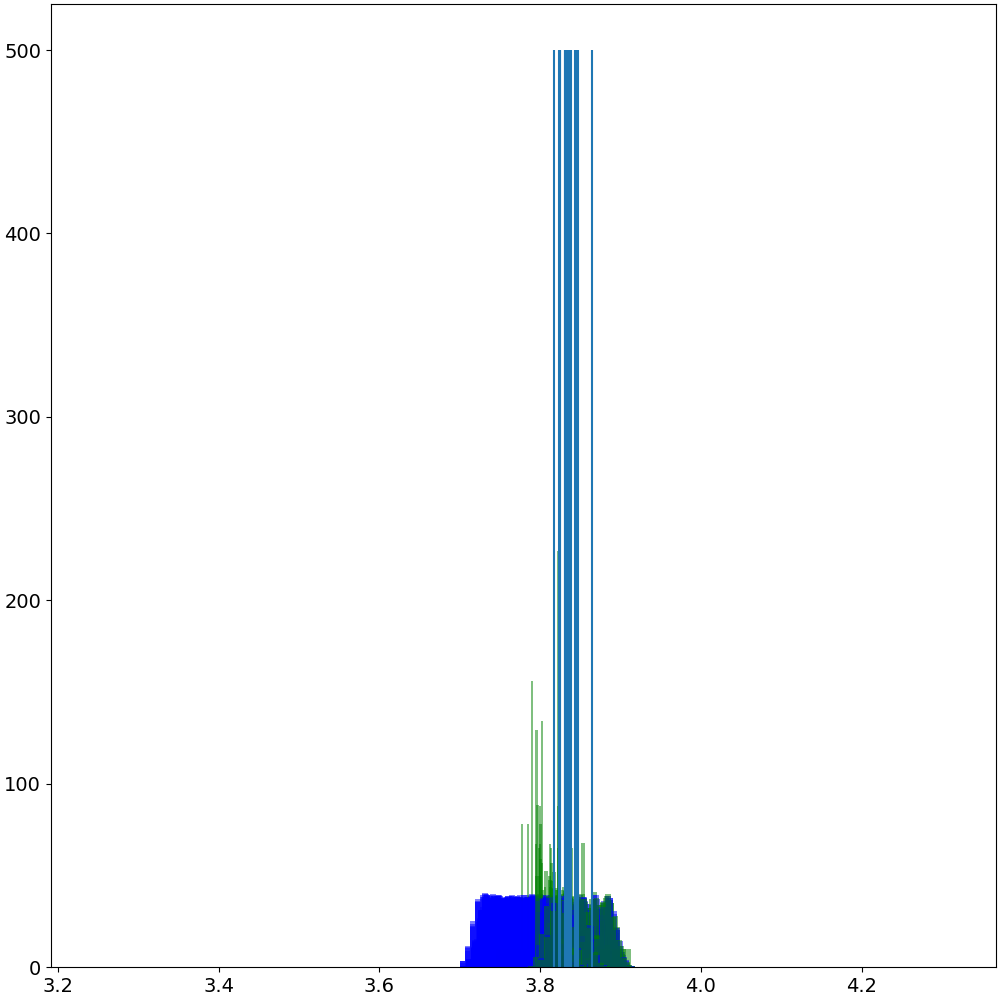

In [73]:
def plot_normal_distributions(both_profiles, both_uncertanties, integer_masks, pulse_rmids, ): 
    """
    Plots the normal distributions to be plotted 
    """
    
    ubound_tsep=120
    lbound_tsep=80
    rad_var = 0.01
    
    # lbound_n, ubound_n, 
    lbound_t, ubound_t = 0, 1000
    lbound_tsep = 80, 
    ubound_tsep = 120
    
    # d_profs, t_profs = both_profiles[:, 0, :], both_profiles[:, 1, :]
    # dne_profs, dte_profs = both_uncertanties[:, 0, :], both_uncertanties[:, 1, :]
    fig = plt.figure(constrained_layout=True, figsize=(10, 10))
    
    pulse_rseps = []
    for slc, (both_profiles_slice, both_uncerts_slice, rmid_slice, mask_slice) in enumerate(zip(both_profiles, both_uncertanties, pulse_rmids, integer_masks)):
        bool_mask = mask_slice > 0
        
        slice_ne, slice_te = both_profiles_slice[0, :][bool_mask], both_profiles_slice[1, :][bool_mask] 
        slice_ne_uncert, slice_te_uncert = both_uncerts_slice[0, :][bool_mask], both_uncerts_slice[1, :][bool_mask] 
        slice_rmid = rmid_slice[bool_mask]
        
        sep_diff = slice_te - 100
        if (sep_diff < 0).any() == False:
            continue
        else: 
            idx_tlower_bound = np.argwhere(sep_diff < 0)[0][0]
            idx_thigher_bound = idx_tlower_bound -1
        
        # Location of the points that should be between separatrix 
        ubound_r = slice_rmid[idx_tlower_bound] + 0.05
        lbound_r = slice_rmid[idx_thigher_bound] - 0.05
        ubound_r = 4.0
        lbound_r = 3.7
        
        radii_gaussians = np.array([truncnorm.rvs((lbound_r - mu) / var, (ubound_r - mu) / var, mu, var, 10000) for mu, var in zip(slice_rmid, [rad_var]*len(slice_rmid))])
        tes_gaussians = np.array([truncnorm.rvs((lbound_t - mu) / var, (ubound_t - mu) / var, mu, var, 10000) for mu, var in zip(slice_te, slice_te_uncert)])
        separatrix_loc = np.logical_and(tes_gaussians >= lbound_tsep, tes_gaussians <= ubound_tsep)
        plt.vlines(radii_gaussians[separatrix_loc].mean(), 0, 500)
        for rad, tes in zip(radii_gaussians, tes_gaussians):
            separatrix_loc = np.logical_and(tes >= lbound_tsep, tes <= ubound_tsep)
            plt.hist(rad, density=True, alpha=0.5, color='blue')
            plt.hist(rad[separatrix_loc], density=True, alpha=0.5, color='green')
        
        
    plt.show()
    
    

def look_at_normals(set_ids, set_profiles, set_uncerts, set_masks, set_shot_numbers_by_slice, set_rmids, set_time_pulse_ids, set_elm_timings_by_pulse, pedestal_database): 
    iterator = tqdm(range(len(set_ids)))
    
    neseps_means_real_pred_lorenzo = np.zeros((3, len(set_ids)))
    nesep_real_means_by_pulse, nesep_pred_means_by_pulse = [], []
    for k in iterator: 
        slice_loc_in_set = set_ids[k]
        if len(slice_loc_in_set) == 0: 
            continue
        pulse_number = np.array(set_shot_numbers_by_slice)[set_ids[k]][0]
        
        if pulse_number != 84487: #87305 low vals
            continue
        
        if pulse_number in [86644, 96922]: 
            index_to_take_from = 1
        else: 
            index_to_take_from = 0
            
        
        JPDB_pulse = pedestal_database[pedestal_database['shot'] == pulse_number]
        
        # print((JPDB_pulse[['t1', 't2', 'nepedheight10^19(m^-3)']]))
        lorenzo_nesep  = JPDB_pulse[['neseparatrixfromexpdata10^19(m^-3)', 'neseparatrixfromfit10^19(m^-3)']].values[index_to_take_from]
        # print(lorenzo_nesep)
        lorenzo_fit_ne = np.array([JPDB_pulse['nepedheight10^19(m^-3)'].values[index_to_take_from], 0.0,  JPDB_pulse['nepositionRmid(m)'].values[index_to_take_from],0.01*JPDB_pulse['NepedestalwidthRmid(cm)'].values[index_to_take_from],JPDB_pulse['neinnerslope'].values[index_to_take_from], ])
        lorenzo_fit_te = np.array([JPDB_pulse['Tepedheight(keV)'].values[index_to_take_from], 0.0,  JPDB_pulse['TepositionRmid(m)'].values[index_to_take_from],0.01*JPDB_pulse['TepedestalwidthRmid(cm)'].values[index_to_take_from],JPDB_pulse['Teinnerslope'].values[index_to_take_from], ])
        
        lorenzo_nesep_exp, lorenzo_nesep_fit = lorenzo_nesep
    
        sample_profiles, sample_uncerts, sample_masks, sample_rmids = set_profiles[slice_loc_in_set], set_uncerts[slice_loc_in_set], set_masks[slice_loc_in_set], set_rmids[slice_loc_in_set]
        
        sample_elm_timings = set_elm_timings_by_pulse[slice_loc_in_set]
        
        pulse_neseps, pulse_teseps = 0.0, 0.0# calculate_nesep_for_pulse(sample_profiles, sample_uncerts, sample_masks, lbound_n = 0, ubound_n = 0.5e21, lbound_t=0, ubound_t=2000)
        plot_normal_distributions(sample_profiles, sample_uncerts, sample_masks,sample_rmids)
                
        iterator.set_description_str(str(pulse_number))
        
        
        
    return None

look_at_normals(train_new_pulse_ids, train_X, train_uncert, train_mask, train_pulse_order, train_real_space_radii, train_ids, train_elm_percentages, pedestal_database=JET_PDB)

In [ ]:
train_nesep_means_lorenzo, train_nesep_by_pulse, train_tesep_means_lorenzo, train_tesep_by_pulse, train_nesep_by_pulse_masked = calculate_neseps_in_set(test_pulse_idxs, test_X, test_uncert, test_mask, test_pulse_order,test_real_space_radii,  test_new_pulse_ids, JET_PDB, ubound_tsep=130, lbound_tsep=70, rad_var=0.02)

In [ ]:
train_nesep_means_lorenzo, train_nesep_by_pulse, train_tesep_means_lorenzo, train_tesep_by_pulse, train_nesep_by_pulse_masked = calculate_neseps_in_set(train_pulse_idxs, train_X, train_uncert, train_mask, train_pulse_order, train_real_space_radii, train_new_pulse_ids, JET_PDB, ubound_tsep=120, lbound_tsep=80, rad_var=0.015)
# val_nesep_means_lorenzo, val_nesep_by_pulse, val_tesep_means_lorenzo, val_tesep_by_pulse, val_elm_by_pulse, val_nesep_by_pulse_masked = calculate_neseps_in_set(val_pulse_idxs, val_X, val_uncert, val_mask, val_pulse_order, val_real_space_radii, val_elm_timings, JET_PDB)
# test_nesep_means_lorenzo, test_nesep_by_pulse, test_tesep_means_lorenzo, test_tesep_by_pulse, test_elm_by_pulse, test_nesep_by_pulse_masked = calculate_neseps_in_set(test_pulse_idxs, test_X, test_uncert, test_mask, test_pulse_order,test_real_space_radii, test_elm_timings,  JET_PDB)
# train_nesep_means_lorenzo, train_nesep_by_pulse, train_tesep_means_lorenzo, train_tesep_by_pulse, train_nesep_by_pulse_masked  = calculate_neseps_in_set(test_pulse_idxs, test_X, test_uncert, test_mask, test_pulse_order,test_real_space_radii,  JET_PDB, ubound_tsep=110, lbound_tsep=90)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10, 5), constrained_layout=True)


axs[0].scatter(train_nesep_means_lorenzo[1], 1e-19*train_nesep_means_lorenzo[0], label='Train')
axs[0].scatter(val_nesep_means_lorenzo[1], 1e-19*val_nesep_means_lorenzo[0], label='Valid')
axs[0].scatter(test_nesep_means_lorenzo[1], 1e-19*test_nesep_means_lorenzo[0], label='Test')
axs[0].plot(train_nesep_means_lorenzo[1], train_nesep_means_lorenzo[1], color='black')
axs[0].plot(train_nesep_means_lorenzo[1], 0.7*train_nesep_means_lorenzo[1], color='red')
axs[0].legend()

axs[1].scatter(1e-19*train_nesep_means_lorenzo[0], train_tesep_means_lorenzo, label='Train')
axs[1].scatter(1e-19*val_nesep_means_lorenzo[0], val_tesep_means_lorenzo, label='Valid')
axs[1].scatter(1e-19*test_nesep_means_lorenzo[0], test_tesep_means_lorenzo, label='Test')
axs[1].scatter(1e-19*train_nesep_means_lorenzo[0][np.argmax(train_nesep_means_lorenzo[1])], train_tesep_means_lorenzo[np.argmax(train_nesep_means_lorenzo[1])], s=75, color='red')


plt.show()

/tmp/ipykernel_108090/90653570.py:30: UserWarning: You passed a edgecolor/edgecolors ((0, 0, 0)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs.scatter([train_nesep_means_lorenzo[1, n]]*2, first_order, color='green', zorder=10, edgecolor=(0, 0, 0), s=70, marker = '+', alpha=0.4)


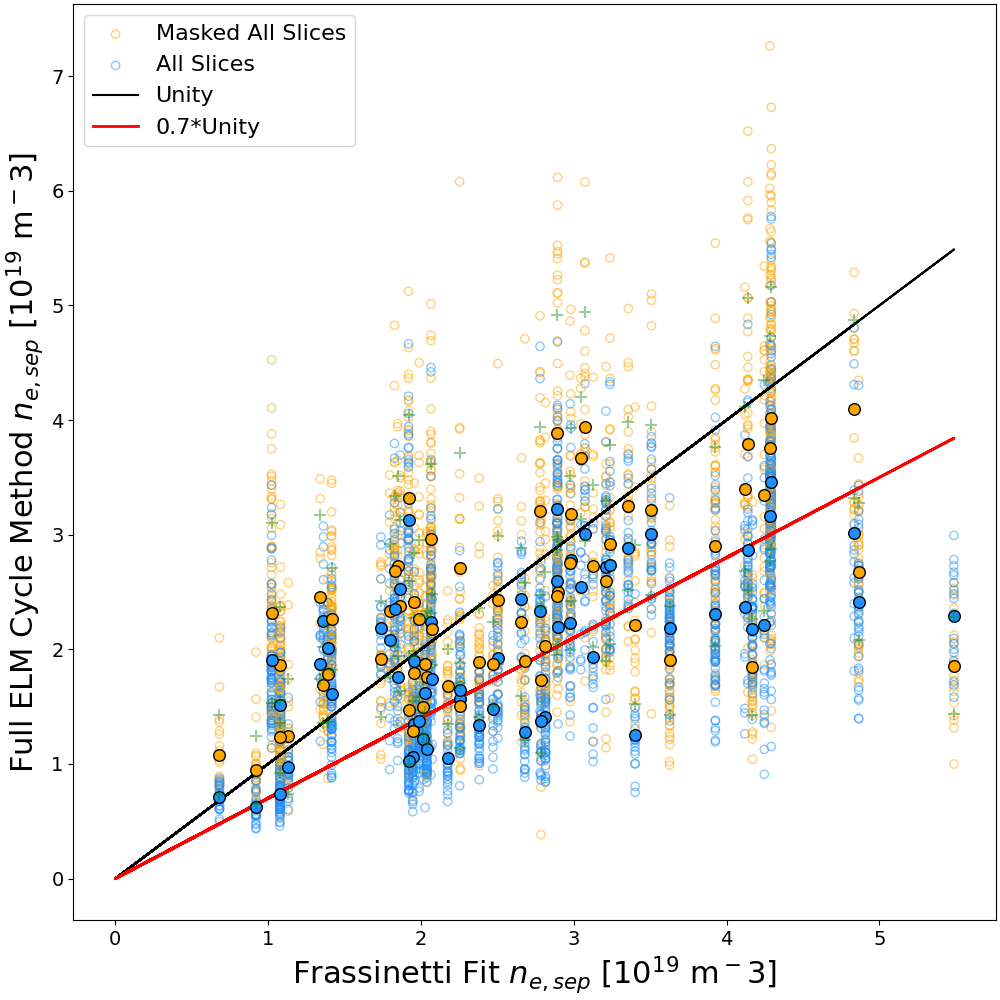

In [78]:
plt.close('all')
def corr2hex(n):
    ''' Maps a number in [0, 1] to a hex string '''
    if np.isnan(n): return plt.cm.Greys(0)
    else: 
        # print('#' + hex(int(n * 16**6))[2:].zfill(6))
        return plt.cm.plasma(n)

fig, axs = plt.subplots(1, 1, figsize=(10, 10), constrained_layout=True)
idx = []
for n, (pulse_masked, pulse) in enumerate(zip(train_nesep_by_pulse_masked, train_nesep_by_pulse)): 
    if n == 0: 
        label_mask = 'Masked All Slices'
        label = 'All Slices'
    else: 
        label_mask = None
        label = None
    # if pulse.std() > 0.55e19 or np.isnan(pulse.std()): 
    #     continue
    if train_nesep_means_lorenzo[1, n] == 0.0: 
        continue
    if pulse_masked[np.invert(np.isnan(pulse_masked))].std() >  5e19: 
        continue
    # print(pulse, pulse_elm)
    # elm_color_map = [corr2hex(x) for x in pulse_elm]
    axs.scatter([train_nesep_means_lorenzo[1, n]]*len(pulse), 1e-19*pulse_masked, facecolors='none', edgecolor='orange', alpha=0.5, zorder=0, label=label_mask, cmap='blues')
    axs.scatter([train_nesep_means_lorenzo[1, n]]*len(pulse), 1e-19*pulse, facecolors='none', edgecolor='dodgerblue', alpha=0.5, zorder=0, label=label, cmap='blues')
    axs.scatter(train_nesep_means_lorenzo[1, n], 1e-19*pulse[np.invert(np.isnan(pulse))].mean(), color='dodgerblue', zorder=10, edgecolor=(0, 0, 0), s=70)
    first_order = [1e-19*pulse_masked[np.invert(np.isnan(pulse_masked))].mean() - 1e-19*pulse_masked[np.invert(np.isnan(pulse_masked))].std(), 1e-19*pulse_masked[np.invert(np.isnan(pulse_masked))].mean() + 1e-19*pulse_masked[np.invert(np.isnan(pulse_masked))].std()]
    axs.scatter([train_nesep_means_lorenzo[1, n]]*2, first_order, color='green', zorder=10, edgecolor=(0, 0, 0), s=70, marker = '+', alpha=0.4)
    
    axs.scatter(train_nesep_means_lorenzo[1, n], 1e-19*pulse_masked[np.invert(np.isnan(pulse_masked))].mean(), color='orange', zorder=10, edgecolor=(0, 0, 0), s=70)
    

# axs.scatter(train_nesep_means_lorenzo[1], 1e-19*train_nesep_means_lorenzo[0], color='forestgreen', zorder=10, edgecolor=(0, 0, 0), label='Pulse Mean', s=70)
# axs.scatter(train_nesep_means_lorenzo[1], 1e-19*train_nesep_means_lorenzo[2], color='violet', zorder=10, edgecolor=(0, 0, 0), label='Masked Pulse Mean', s=70)
axs.plot(train_nesep_means_lorenzo[1], train_nesep_means_lorenzo[1], color='black', label='Unity')
axs.plot(train_nesep_means_lorenzo[1], 0.7*train_nesep_means_lorenzo[1], color='red', label='0.7*Unity', lw=2)
axs.legend()
axs.set_ylabel('Full ELM Cycle Method $n_{e, sep}$ [$10^{19}$ m$^-3$]',)
axs.set_xlabel('Frassinetti Fit $n_{e, sep}$ [$10^{19}$ m$^-3$]',)
# plt.colorbar(cm.ScalarMappable(norm=None, cmap=plt.cm.plasma), label='ELM Percentage')
plt.show()

In [ ]:
import seaborn as sns
plt.close('all') 

final_list_neseps, final_list_elm_timings = [], []# [x for x in by_pulse for by_pulse in train_nesep_by_pulse]
for n, (pulse, pulse_elm) in enumerate(zip(train_nesep_by_pulse, train_elm_by_pulse)): 
#     nan_check = np.logical_and(np.invert(np.isnan(pulse_elm)), np.invert(np.isnan(pulse)))
    final_list_neseps.extend(pulse)
    final_list_elm_timings.extend(pulse_elm)
sns.histplot(x=final_list_neseps, y = final_list_elm_timings)
    
plt.show()

In [ ]:
fig = plt.figure()

plt.scatter(train_means_lorenzo[1], 1e-19*train_means_lorenzo[0])
plt.plot(train_means_lorenzo[1], train_means_lorenzo[1])
plt.plot(train_means_lorenzo[1], 0.7*train_means_lorenzo[1], color='red')
plt.show()

In [ ]:
model_hyperparams_physics = {'in_ch': 2, 'out_length':19,
                    'mach_latent_dim': 9, 'stoch_latent_dim': 3,
                    'beta_stoch': 1.0, 'beta_mach_unsup':  0.001,'beta_mach_sup':  0.0,
                    'alpha_mach': 1.0, 'alpha_prof': 20.0,  # 212, 306, 26, 295, 263, 336] 	[485, 499, 352, 432]
                    'start_sup_time': 1000,
                    'physics': False, 'gamma_stored_energy': 1.0, 'gamma_bpol': 1.0, 'gamma_beta': 1.0, 
                    'mp_hdims_aux': [64, 32], 'mp_hdims_cond':[64, 32], # 'mp_hdims_aux': [263, 469, 284], 'mp_hdims_cond':[20, 136, 54, 205, 154, 408], # 'mp_hdims_cond': [397, 369, 29, 113, 284], 'mp_hdims_aux': [122, 398, 463, 354, 399], 
                    'hidden_dims': [2, 4], 'loss_type': 'semi-supervised',}
model_physics = DIVAMODEL(**model_hyperparams_physics)
model_name_physics = 'modelstatedict_SECULAR_semi-supervised-cutoffLOSS_9MD_3SD_0BMUN_15.0BMSUP_5.0BS_500AM_379AP_50EP' # Helsinki desktop example
# model_name_physics = 'modelstatedict_SCHEDULER_PHYSICS_9MD_3SD_0BMUN_10.0BMSUP_1.5BS_500AM_960AP_50EP_100.0GAMMA' # Home Laptop Example
state_dict = torch.load('../Find_optimal_model/model_results/{}.pth'.format(model_name_physics))
# model_physics.load_state_dict(state_dict['model'])

# Convert things to tensors 
norms_MP, norms_D, norms_T = state_dict['MP_norms'], state_dict['D_norms'], state_dict['T_norms']
MP_norm, MP_var = norms_MP
D_norm, D_var = norms_D
T_norm, T_var = norms_T


all_masks = np.vstack((train_mask, val_mask, test_mask)) > 0
all_psis = np.vstack((train_radii, val_radii, test_radii))
all_rmids = np.vstack((train_real_space_radii, val_real_space_radii, test_real_space_radii))

# Training Tensors 

train_mp_tensors = torch.tensor(train_y).float()
val_mp_tensors = torch.tensor(val_y).float()
test_mp_tensors = torch.tensor(test_y).float()
all_mp_tensors = torch.vstack((train_mp_tensors, val_mp_tensors, test_mp_tensors))


train_mp_normalized = standardize(train_mp_tensors, MP_norm, MP_var)
val_mp_normalized = standardize(val_mp_tensors, MP_norm, MP_var)
test_mp_normalized = standardize(test_mp_tensors, MP_norm, MP_var)

train_profiles = torch.tensor(train_X).float()
val_profiles = torch.tensor(val_X).float()
test_profiles = torch.tensor(test_X).float()
all_profiles = torch.vstack((train_profiles, val_profiles, test_profiles))

train_profiles_normalized = torch.clone(train_profiles).float()
train_profiles_normalized = normalize_profiles(train_profiles_normalized, T_norm, T_var, D_norm, D_var)

val_profiles_normalized = torch.clone(val_profiles).float()
val_profiles_normalized = normalize_profiles(val_profiles_normalized, T_norm, T_var, D_norm, D_var)

test_profiles_normalized = torch.clone(test_profiles).float()
test_profiles_normalized = normalize_profiles(test_profiles_normalized, T_norm, T_var, D_norm, D_var)


In [ ]:
def calculate_neseps_in_set_with_predictions(set_ids, set_profiles, set_uncerts, set_masks, set_shot_numbers_by_slice, set_mps, pedestal_database): 
    iterator = tqdm(range(len(set_ids)))
    
    neseps_means_real_pred_lorenzo = np.zeros((3, len(set_ids)))
    nesep_real_means_by_pulse, nesep_pred_means_by_pulse = [], []
    for k in iterator: 
        slice_loc_in_set = set_ids[k]
        pulse_number = np.array(set_shot_numbers_by_slice)[set_ids[k]][0]
        
        
        JPDB_pulse = pedestal_database[pedestal_database['shot'] == pulse_number]
        lorenzo_nesep  = JPDB_pulse[['neseparatrixfromexpdata10^19(m^-3)', 'neseparatrixfromfit10^19(m^-3)']].values[0]
     
        lorenzo_nesep_exp, lorenzo_nesep_fit = lorenzo_nesep
    
        sample_profiles, sample_uncerts, sample_masks, sample_mps = set_profiles[slice_loc_in_set], set_uncerts[slice_loc_in_set], set_masks[slice_loc_in_set], set_mps[slice_loc_in_set]
        
            
        pulse_real_neseps = calculate_nesep_for_pulse(sample_profiles, sample_uncerts, sample_masks, lbound_n = 0, ubound_n = 0.5e21, lbound_t=0, ubound_t=2000)
        
        # Get conditional preds
        conditional_profiles = conditional_inference_simple_mean((sample_profiles, _, sample_masks, _, sample_mps, _, _), model_physics)
        pulse_preds_neseps = calculate_nesep_for_pulse(conditional_profiles, sample_uncerts, sample_masks, lbound_n = 0, ubound_n = 0.5e21, lbound_t=0, ubound_t=2000, conditional_prediction=True)
        
        
        mean_real_pulse_nesep = pulse_real_neseps.mean()
        mean_pred_pulse_nesep = pulse_preds_neseps.mean()
        
        neseps_means_real_pred_lorenzo[:, k] = [mean_real_pulse_nesep, mean_pred_pulse_nesep, lorenzo_nesep_exp]
        
        nesep_real_means_by_pulse.append(pulse_real_neseps)
        nesep_pred_means_by_pulse.append(pulse_preds_neseps)
        
        iterator.set_description_str(str(pulse_number))
        iterator.set_postfix_str('fras{:.3}mean{:.4}pred{:.4}'.format(lorenzo_nesep_exp, 1e-19*mean_real_pulse_nesep, 1e-19*mean_pred_pulse_nesep ))
        
        
        
    return neseps_means_real_pred_lorenzo, nesep_real_means_by_pulse, nesep_pred_means_by_pulse


In [ ]:
neseps_conditional_real_lorenzo, neseps_real_by_pulse, neseps_conditional_by_pulse = calculate_neseps_in_set_with_predictions(train_pulse_idxs, train_profiles, train_uncert, train_mask, train_pulse_order, train_mp_tensors, JET_PDB)
# train_means_lorenzo, train_by_pulse = calculate_neseps_in_set(train_pulse_idxs, train_X, train_uncert, train_mask, train_pulse_order, JET_PDB)

In [ ]:
plt.close('all')
fig, axs = plt.subplots(1, 1, figsize=(8, 8), constrained_layout=True)
for n, (pulse_real, pulse_cond) in enumerate(zip(neseps_real_by_pulse, neseps_conditional_by_pulse)): 
    if n == 0: 
        label = 'All Slices'
    else: 
        label = None
    axs.scatter(pulse_real, pulse_cond, facecolors='none', edgecolor='dodgerblue', alpha=0.5, zorder=0, label=label)
    axs.plot(pulse_real, pulse_real, color='black')
    axs.plot(pulse_real, 1.2*pulse_real, color='black',ls='--')
    axs.plot(pulse_real, 0.8*pulse_real, color='black',ls='--')
    
axs.scatter(neseps_conditional_real_lorenzo[0], neseps_conditional_real_lorenzo[1], color='forestgreen', zorder=10, edgecolor=(0, 0, 0), label='Pulse Mean', s=70)
axs.plot(neseps_conditional_real_lorenzo[0], neseps_conditional_real_lorenzo[0], color='black', label='Unity')
axs.legend()
axs.set_xlabel('Full ELM Cycle Method $n_{e, sep}$ [$10^{19}$ m$^-3$]',)
axs.set_ylabel('Predicted $n_{e, sep}$ [$10^{19}$ m$^-3$]',)
plt.show()

In [ ]:
line_of_sight = pd.read_csv('/home/adam/Desktop/pulse_91962_line_of_sight.dat', skiprows=4, names=['R', 'NE'], sep='  ')['R'].to_list()

In [ ]:
def corr2hex_nete(n, dtype='density'):
    ''' Maps a number in [0, 1] to a hex string '''
    
    if dtype=='density': 
        if np.isnan(n): 
            return plt.cm.viridis(0)
        else: 
            return plt.cm.Blues(n)
    elif dtype=='temperature': 

        if np.isnan(n): 
            return plt.cm.viridis(0)
        else: 
            return plt.cm.Oranges(n)
    elif dtype=='separatrix': 

        if np.isnan(n): 
            return plt.cm.viridis(0)
        else: 
            return plt.cm.Reds(n)
    


def plot_profiles_and_mtanh(profiles, rmids, masks, uncerts, lorenzo_fit_ne, lorenzo_fit_te, lorenzo_nesep, pulse_neseps, pulse_teseps, pulse_elm_timings):
    d_profs, t_profs = profiles[:, 0, :], profiles[:, 1, :]
    dne_profs, dte_profs = uncerts[:, 0, :], uncerts[:, 1, :]

    # FIGURE SETUP
    fig = plt.figure(constrained_layout=True, figsize=(20, 12))
    
    gs1 = GridSpec(2, 1, left=0.05, right=0.48, wspace=0.05)
    ax2 = fig.add_subplot(gs1[0])
    ax1 = fig.add_subplot(gs1[1])
    
    ax1.set_xlabel('$T_e$ [eV]')
    ax2.set_xlabel('$n_e$ [m$^{-3}$]')
    ax2.set_ylabel('PDF')
    ax1.set_ylabel('PDF')
    
    gs2 = GridSpec(2, 1, left=0.55, right=0.98, hspace=0.0)
    ax3 = fig.add_subplot(gs2[0])
    ax4 = fig.add_subplot(gs2[1])
    
    ax4.set_ylabel('$T_e$ [eV]')
    ax4.set_xlabel('HRTS Line of Sight [m]')
    ax3.set_ylabel('$n_e$ [m$^{-3}$]')

    
    mtanh_radius = np.linspace(3.78, 3.9, 400)
    low_t, high_t = 80, 120
    offset = 0.022
    
    myclip_a, myclip_b = 0, 1000
    myclip_an, myclip_bn = 0, 1.0e20
    var_radius = 0.0055
    SOL_size_cm = 0.02
    
    
    pulse_neseps = []
    cutoffs = []
    teseps_cutoff = []
    pulse_elm_timings = np.ones(len(d_profs))
    for sl, (d_pr, t_pr, dne_pr, dte_pr, radius, mask, elm) in enumerate(zip(d_profs, t_profs, dne_profs, dte_profs, rmids, masks, pulse_elm_timings)):
        bool_mask = mask > 0
        slice_neseps, slices_rmids, slices_tseps = [], [], []
        bool_mask = np.logical_and(bool_mask, dne_pr < 1e19)
        d_prm, t_prm, dne_prm, dte_prm, rmid_prm = d_pr[bool_mask], t_pr[bool_mask], dne_pr[bool_mask], dte_pr[bool_mask], radius[bool_mask]
        
        for mea, (mu_t, var_t, mu_n, var_n, rad) in enumerate(zip(t_prm, dte_prm, d_prm, dne_prm, rmid_prm)): 
            a, b = (3.7 - rad) /var_radius, (3.9 - rad) / var_radius
            rmid_sample = np.linspace(truncnorm.ppf(0.01, a, b, rad, var_radius), truncnorm.ppf(0.99, a, b, rad, var_radius), 10000)
            a, b = (myclip_a - mu_t) / var_t, (myclip_b - mu_t) / var_t
            x_t = np.linspace(truncnorm.ppf(0.01, a, b, mu_t, var_t), truncnorm.ppf(0.99, a, b, mu_t, var_t), 10000)
            
            separatrix_loc = np.logical_and(x_t>low_t, x_t<high_t)
            x_tesep = x_t[separatrix_loc]
            
            rmid_tesep = rmid_sample[separatrix_loc]
            slices_rmids.extend(rmid_tesep)
            slices_tseps.extend(x_tesep)
        rmid_cutoff = np.mean(slices_rmids)
        teseps_cutoff.append(np.mean(slices_tseps))
        cutoffs.append(rmid_cutoff)
    
    rmid_cutoff = np.mean(cutoffs)
    print(rmid_cutoff)
    for sl, (d_pr, t_pr, dne_pr, dte_pr, radius, mask, elm) in enumerate(zip(d_profs, t_profs, dne_profs, dte_profs, rmids, masks, pulse_elm_timings)):
        bool_mask = mask > 0
        slice_neseps, slices_rmids, slices_tseps = [], [], []
        bool_mask = np.logical_and(bool_mask, dne_pr < 1e19)
        d_prm, t_prm, dne_prm, dte_prm, rmid_prm = d_pr[bool_mask], t_pr[bool_mask], dne_pr[bool_mask], dte_pr[bool_mask], radius[bool_mask]
        
        for meat, (mu_t, var_t, mu_n, var_n, rad) in enumerate(zip(t_prm, dte_prm, d_prm, dne_prm, rmid_prm)): 
            
            if meat == 0 and sl == 0: 
                label_t_sep  = '95 < $T_e$ < 105' 
            else: 
                label_t_sep = None
            if ((rad > rmid_cutoff + SOL_size_cm) or (rad < rmid_cutoff - SOL_size_cm)): 
                continue   
            
            a, b = (3.7 - rad) /var_radius, (3.9 - rad) / var_radius
            
            a, b = (myclip_a - mu_t) / var_t, (myclip_b - mu_t) / var_t
            x_t = np.linspace(truncnorm.ppf(0.01, a, b, mu_t, var_t), truncnorm.ppf(0.99, a, b, mu_t, var_t), 10000)
            
            separatrix_loc = np.logical_and(x_t>low_t, x_t<high_t)
            x_tesep = x_t[separatrix_loc]
            
            a, b = (myclip_an - mu_n) / var_n, (myclip_bn - mu_n) / var_n
            x = np.linspace(truncnorm.ppf(0.01, a, b, mu_n, var_n),

                            truncnorm.ppf(0.99, a, b, mu_n, var_n), 10000)

            x_nesep = x[separatrix_loc]
            
            a, b = (myclip_a - mu_t) / var_t, (myclip_b - mu_t) / var_t
            ax1.plot(x_t, truncnorm.pdf(x_t, a, b, mu_t, var_t),
               'b-', lw=1, alpha=0.6, zorder=10)
            ax1.plot(x_tesep, truncnorm.pdf(x_tesep, a, b, mu_t, var_t),
                'g-', lw=3, alpha=0.6, label=label_t_sep, zorder=20)
            
            a, b = (myclip_an - mu_n) / var_n, (myclip_bn - mu_n) / var_n
            ax2.plot(x, truncnorm.pdf(x, a, b, mu_n, var_n),
                   'b-', lw=1, alpha=0.6, zorder=10)
            ax2.plot(x_nesep, truncnorm.pdf(x_nesep, a, b, mu_n, var_n),
                   'g-', lw=3, alpha=0.99, zorder=20, label=label_t_sep)
            
            slice_neseps.extend(x_nesep)
            
        pulse_neseps.append(np.mean(slice_neseps))
            
        
        ax3.scatter(radius[bool_mask], d_pr[bool_mask], color=corr2hex_nete(elm), edgecolor=(0, 0, 0), zorder=20, s=75)
        ax4.scatter(radius[bool_mask], t_pr[bool_mask], color=corr2hex_nete(elm, 'temperature'), edgecolor=(0, 0, 0), zorder=0, s=75)
    
    
    lor_tsep_loc = mtanh_radius[np.argmin(abs(1e3*mtanh(mtanh_radius, *lorenzo_fit_te) - 0.1))]
    # offset = rmid_cutoff - lor_tsep_loc
    
    
    ax3.plot(mtanh_radius - offset + 0.005, 1e19*mtanh(mtanh_radius, *lorenzo_fit_ne), color='blue', lw=4, zorder=30, label='Frassinetti Fit')
    ax4.plot(mtanh_radius - offset+ 0.005, 1e3*mtanh(mtanh_radius, *lorenzo_fit_te), color='orange', lw=4, label='Frassinetti Fit')
    
    # ax4.vlines(rmid_cutoff, 0, 1000, color='black', lw=3, label='$R(T_e = 100$ [eV])')
    # ax3.vlines(rmid_cutoff, -1e19, 1e20, color='black', lw=3, label='$R(T_e = 100$ [eV])')
    # ax4.vlines([rmid_cutoff+SOL_size_cm, rmid_cutoff-SOL_size_cm], 0, 1000, color='black', lw=3, label='R Cutoff')
    # ax3.vlines([rmid_cutoff+SOL_size_cm, rmid_cutoff-SOL_size_cm], -1e19, 1e20, color='black', lw=3)
    
    
    ax4.set_ylim(-50, 950)
    ax3.set_ylim(-0.5e19, 1.15e20)
    ax2.set_ylim(0.1e-20, 1.8e-19)
    
    # ax4.hlines(pulse_teseps, 3.79, 3.82, color='red', ls='--')
    ax4.hlines(100, rmid_cutoff-SOL_size_cm, rmid_cutoff+SOL_size_cm, color='black', ls='--', label='$T_e = 100$ [eV]')
    ax4.hlines([low_t, high_t], rmid_cutoff-SOL_size_cm, rmid_cutoff+SOL_size_cm, color='black', ls='--', alpha=0.5)
    
    neseps_colors = [corr2hex_nete(x, 'separatrix') for x in pulse_elm_timings]
    ax3.hlines(lorenzo_nesep*1e19, rmid_cutoff-SOL_size_cm, rmid_cutoff+SOL_size_cm, lw=3, color='magenta', ls='--', label='$n_{e, sep}$ Frassinetti', zorder=15)
    # ax3.hlines(pulse_neseps, 3.79, 3.83, color=neseps_colors, lw=3, ls='--', label='$n_{e, sep}$ Kit', zorder=15)
    
    print(np.std(pulse_neseps))
    ax2.vlines(pulse_neseps, 2e-20, 1.0e-19, color=neseps_colors, ls='--', label='$n_{e, sep}$ Kit', zorder=15, lw=3)
    ax2.vlines(lorenzo_nesep*1e19, 2e-20, 1.0e-19, color='magenta', ls='--', label='$n_{e, sep}$ Frassinetti', zorder=15, lw=6)
    
    ax4.scatter([rmid_cutoff]*len(teseps_cutoff),teseps_cutoff,color='gold')
    ax3.scatter([rmid_cutoff]*len(pulse_neseps), pulse_neseps,color=neseps_colors, label='$n_{e, sep}$ Kit', zorder=15)
    axs= [ax1, ax2, ax3, ax4]
    for ax in axs: 
        ax.legend()
    fig.suptitle('Pulse 91962, 52.48s -> 53.43s')
    ax2.set_title('$n_{e,sep}$ approximation via normal distributions')
    ax3.set_title('Profile and Fit comparisons')
    # plt.savefig('./pulse_91962_nesep_comparison.png')
    plt.show()
    pass 
def look_at_high_nesep(set_ids, set_profiles, set_uncerts, set_masks, set_shot_numbers_by_slice, set_rmids, set_time_pulse_ids, set_elm_timings_by_pulse, pedestal_database): 
    iterator = tqdm(range(len(set_ids)))
    
    neseps_means_real_pred_lorenzo = np.zeros((3, len(set_ids)))
    nesep_real_means_by_pulse, nesep_pred_means_by_pulse = [], []
    for k in iterator: 
        slice_loc_in_set = set_ids[k]
        pulse_number = np.array(set_shot_numbers_by_slice)[set_ids[k]][0]
        
        if pulse_number != 84487: #87305 low vals
            continue
        
        if pulse_number in [86644, 96922]: 
            index_to_take_from = 1
        else: 
            index_to_take_from = 0
            
        print(np.array(set_time_pulse_ids)[slice_loc_in_set])
        
        JPDB_pulse = pedestal_database[pedestal_database['shot'] == pulse_number]
        print(len(JPDB_pulse))
        # print((JPDB_pulse[['t1', 't2', 'nepedheight10^19(m^-3)']]))
        lorenzo_nesep  = JPDB_pulse[['neseparatrixfromexpdata10^19(m^-3)', 'neseparatrixfromfit10^19(m^-3)']].values[index_to_take_from]
        # print(lorenzo_nesep)
        lorenzo_fit_ne = np.array([JPDB_pulse['nepedheight10^19(m^-3)'].values[index_to_take_from], 0.0,  JPDB_pulse['nepositionRmid(m)'].values[index_to_take_from],0.01*JPDB_pulse['NepedestalwidthRmid(cm)'].values[index_to_take_from],JPDB_pulse['neinnerslope'].values[index_to_take_from], ])
        lorenzo_fit_te = np.array([JPDB_pulse['Tepedheight(keV)'].values[index_to_take_from], 0.0,  JPDB_pulse['TepositionRmid(m)'].values[index_to_take_from],0.01*JPDB_pulse['TepedestalwidthRmid(cm)'].values[index_to_take_from],JPDB_pulse['Teinnerslope'].values[index_to_take_from], ])
        
        lorenzo_nesep_exp, lorenzo_nesep_fit = lorenzo_nesep
    
        sample_profiles, sample_uncerts, sample_masks, sample_rmids = set_profiles[slice_loc_in_set], set_uncerts[slice_loc_in_set], set_masks[slice_loc_in_set], set_rmids[slice_loc_in_set]
        
        sample_elm_timings = set_elm_timings_by_pulse[slice_loc_in_set]
        print(sample_elm_timings)
        pulse_neseps, pulse_teseps = 0.0, 0.0# calculate_nesep_for_pulse(sample_profiles, sample_uncerts, sample_masks, lbound_n = 0, ubound_n = 0.5e21, lbound_t=0, ubound_t=2000)
        plot_profiles_and_mtanh(sample_profiles, sample_rmids, sample_masks, sample_uncerts, lorenzo_fit_ne, lorenzo_fit_te, lorenzo_nesep_fit, pulse_neseps, pulse_teseps, sample_elm_timings)
                
        iterator.set_description_str(str(pulse_number))
        
        
        
    return None
plt.close('all')
look_at_high_nesep(train_pulse_idxs, train_X, train_uncert, train_mask, train_pulse_order, train_real_space_radii, train_ids, set_elm_timings_by_pulse= np.zeros_like(train_real_space_radii), pedestal_database=JET_PDB)
# look_at_high_nesep(test_pulse_idxs, test_X, test_uncert, test_mask, test_pulse_order, test_real_space_radii, test_ids, test_elm_timings, JET_PDB)

In [ ]:
def conditional_inference_simple_mean(PULSE, model=None, norms=(None, None, None, None)):
    D_norm, D_var, T_norm,T_var = norms
    X, PSI, MASK, ID, MPS, _, UNCERT = PULSE
    X[:, 0] = standardize(X[:, 0], D_norm, D_var)
    X[:, 1] = standardize(X[:, 1], T_norm, T_var)
    MPS = standardize(MPS, MP_norm, MP_var)
    with torch.no_grad():         
        cond_mu, cond_var =  model.p_zmachx(MPS)
        z_mach = model.reparameterize(cond_mu, cond_var)
        mu_stoch, log_var_stoch, mu_mach, log_var_mach = model.q_zy(X)
        z_stoch = mu_stoch
        z_mach = cond_mu
        z_conditional = torch.cat((z_stoch, z_mach), 1)
        out_profs_cond = model.p_yhatz(z_conditional)
    out_profs_cond[:, 0] = de_standardize(out_profs_cond[:, 0], D_norm, D_var)
    out_profs_cond[:, 1] = de_standardize(out_profs_cond[:, 1], T_norm, T_var)
    MPS = de_standardize(MPS, MP_norm, MP_var)
    X[:, 0] = de_standardize(X[:, 0], D_norm, D_var)
    X[:, 1] = de_standardize(X[:, 1], T_norm, T_var)
    return out_profs_cond
from matplotlib.gridspec import GridSpec


In [ ]:

gc

In [ ]:
plt.close('all')

In [ ]:
high_nesep = PULSE_DF_SANDBOX[PULSE_DF_SANDBOX['shot'] == 91962]
high_nesep[['dda', 't1', 't2']]

In [ ]:
PULSE_DF_SANDBOX[['shot', 'dda']]
dda_dict = {'shot': [], 'uid': [], 'dda': []}
for index, row in PULSE_DF_SANDBOX.iterrows(): 

    shot, name = row['shot'], row['dda']
    dda, uid = name.split('/')
    dda_dict['shot'].append(shot)
    dda_dict['dda'].append(dda)
    dda_dict['uid'].append(uid)
    

In [ ]:
with open('../../data/raw/elm_timing_locs_data_SANDBOX_NO_VARIAITONS.pickle', 'wb') as file:
    pickle.dump(dda_dict, file)